## Figuras 47 Tucanae

En el siguiente notebook se han generado las imagenes del trabajo.

### Requirements

In [41]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

import numpy as np
from dotenv import load_dotenv
from google.cloud import storage

import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.skyview import SkyView
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


    
# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../../src"))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
            

from hyper_velocity_stars_detection.sources.source import AstroMetricData, AstroObject
from hyper_velocity_stars_detection.jobs.utils import read_baumgardt_catalog
from hyper_velocity_stars_detection.tools.stadistics_utils import hist_sample
from hyper_velocity_stars_detection.tools.hvs_estimation import get_hvs_candidates
from hyper_velocity_stars_detection.tools.imbh_mass_estimation import v_ejections_sample, sample_mbh, estimate_log10_mbh_from_sigma
from hyper_velocity_stars_detection.tools.cluster_representations import get_best_isochrone_fitted, load_isochrone_from_parsec
from hyper_velocity_stars_detection.globular_clusters import GlobularClusterAnalysis
from hyper_velocity_stars_detection.jobs.google_jobs.utils import load_globular_cluster,load_astrometric_data
from hyper_velocity_stars_detection.variables_names import *

load_dotenv("../../data/.env")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../../data/hvs-storage.json"

PATH = "../../data/report_notebook"

RADIUS_SCALE = 1
CATALOG = "gaiadr3"
FILTERS = {"ast_params_solved": 3, "ruwe": 1.4, "v_periods_used": 10, "min_parallax": 0}
PROJECT = os.environ["PROJECT_ID"]
BUCKET = os.environ["BUCKET"]
BUCKET_PATH = "report/gc_clusters/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Descarga del cúmulo analizado

In [2]:
CLUSTER_NAME = "ngc 104"

gc_object = load_globular_cluster(CLUSTER_NAME, PROJECT, BUCKET, BUCKET_PATH)
print(gc_object)

Muestras seleccionadas del objeto astronómico ngc 104 con radio 1.0:
	 - df_c1 - Todas las estrellas seleccionadas: 96405.
	 - df_c2 - Las estrellas con errores de paralaje y pm menores al 10%: 16239.
	 - df_c3 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 16239.
	 - df_c4 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 30%.: 23393.
Se han encontrado 37 fuentes de rayos X.
Estimated number of clusters: 3
Estimated number of noise points: 1552
	 - Volumen total del cluster 0: 154.
	 - Volumen total del cluster 1: 2658.
	 - Volumen total del cluster 2: 636.



In [64]:
gc_object.describe()

,parallax,pmra,pmdec,bp_rp,phot_g_mean_mag
count,2658.000000,2658.000000,2658.000000,2658.000000,2658.000000
mean,0.227299,5.259595,-2.562610,1.129730,15.022514
std,0.040321,0.389059,0.389883,0.140837,1.315604
min,0.042712,3.634354,-3.864487,0.946924,11.274000
25%,0.207686,5.004244,-2.836276,1.039533,14.267472
50%,0.228277,5.256631,-2.563633,1.077991,15.376552
75%,0.247667,5.511732,-2.288969,1.165925,16.095441
max,0.430296,7.347773,-1.159583,1.815865,16.847569


## Figura fracción descartada de estrellas por filtros

Descargamso los datos sin filtrar para estimar el volumen descartado.

In [4]:
astro_object = AstroObject.get_object("ngc 104")
radius = astro_object.info["ANGULAR_SIZE"][0] / 60
df_tuc =  astro_object.download_data(
        radius=radius,
        catalog_name="gaiadr3",
        ast_params_solved=None,
        ruwe=None,
        v_periods_used=None
    )
df_tuc

,solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
0,1636148068921376768,Gaia DR3 4689621262329503744,4689621262329503744,117828161,2016.0,5.934553,0.537742,-72.252166,0.742929,-2.907118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1636148068921376768,Gaia DR3 4689859169153623936,4689859169153623936,661937160,2016.0,6.723713,0.234891,-71.538202,0.198667,-0.215250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1636148068921376768,Gaia DR3 4688774599718360192,4688774599718360192,652526373,2016.0,5.743721,0.156241,-72.805367,0.141372,0.031388,...,0.0107,0.0025,0.0266,0.0086,0.002,0.0213,0.0047,0.0011,0.0116,MARCS
3,1636148068921376768,Gaia DR3 4688774599718361088,4688774599718361088,249488762,2016.0,5.713389,0.453006,-72.804549,0.428129,-1.306793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1636148068921376768,Gaia DR3 4688774599718363008,4688774599718363008,336417481,2016.0,5.735411,0.206701,-72.802089,0.182867,-0.637711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184934,1636148068921376768,Gaia DR3 4689629985430016512,4689629985430016512,196543525,2016.0,6.828311,2.468688,-72.078526,1.134872,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184935,1636148068921376768,Gaia DR3 4689629985432578560,4689629985432578560,1022114443,2016.0,6.839266,0.203694,-72.074864,0.158569,0.000232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184936,1636148068921376768,Gaia DR3 4689629985432588288,4689629985432588288,93684263,2016.0,6.832372,1.853926,-72.069998,1.529677,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184937,1636148068921376768,Gaia DR3 4689629989704549888,4689629989704549888,1229703459,2016.0,6.847079,1.082456,-72.065732,0.820332,1.939339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Comparamos las estrellas que se han descargado seleccionando las descartadas.

In [70]:
df_data = gc_object.astro_data.get_data("df_c1")
df_descarted = df_tuc[~df_tuc.SOURCE_ID.isin(df_data.SOURCE_ID)]
df_descarted

Se calcula el número de estrellas descartadas dentro del radio $r$.

/tmp/ipykernel_39362/2795064878.py:17: RuntimeWarning: invalid value encountered in divide
  ratio_descarted_2 =descarted_stars/ original_stars


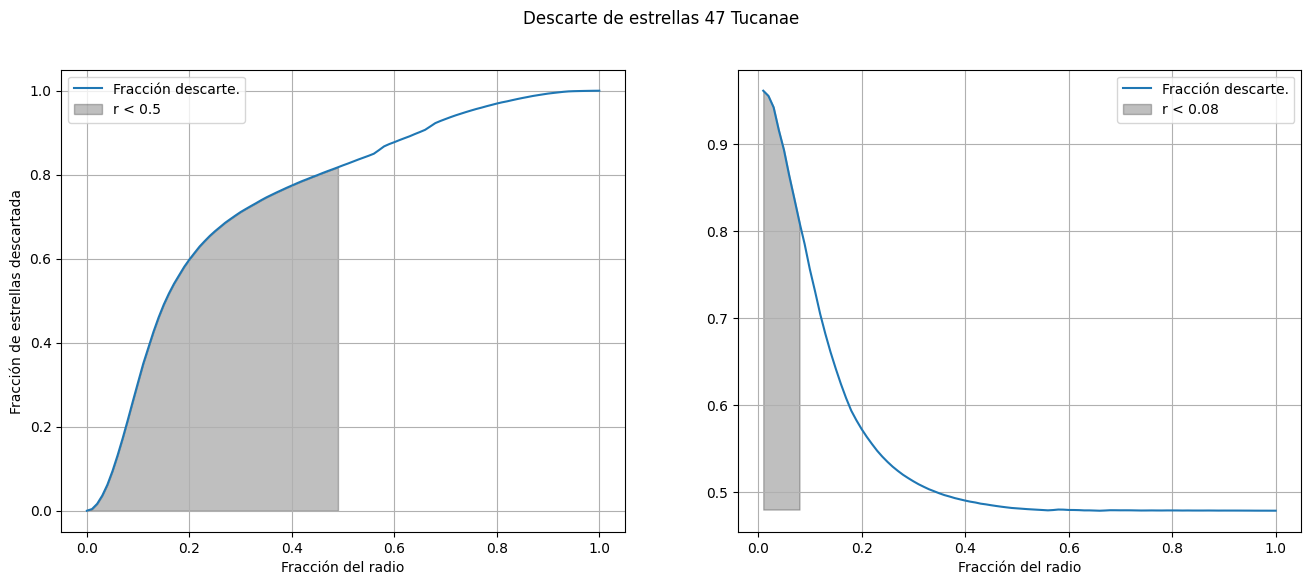

In [126]:
def count_star(center: np.ndarray, df_data: pd.DataFrame, radio: float) -> int:
    distance = np.sqrt((df_data.l - center[0])**2 + (df_data.b - center[1])**2)
    distance = distance / distance.max()
    return (distance<radio).sum()

center = np.array([df_data.l.mean(), df_data.b.mean()])
count_star(center, df_descarted, 0.5)

radio_array = np.linspace(0, 1, 101)
original_stars = np.zeros(101)
descarted_stars = np.zeros(101)
for pos, radio in enumerate(radio_array):
    original_stars[pos] = count_star(center, df_tuc, radio)
    descarted_stars[pos] = count_star(center, df_descarted, radio)

ratio_descarted =descarted_stars/ df_descarted.shape[0]
ratio_descarted_2 =descarted_stars/ original_stars
#plt.plot(radio_array, ratio_descarted)
fig, ax = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle("Descarte de estrellas 47 Tucanae")
ax[0].plot(radio_array, ratio_descarted, label="Fracción descarte.")
ax[0].fill_between(x=radio_array[radio_array<0.5], y1=0, y2=ratio_descarted[radio_array<0.5], color="k", alpha=0.25, label="r < 0.5")
ax[0].set_xlabel("Fracción del radio")
ax[0].set_ylabel("Fracción de estrellas descartada")
ax[0].legend()
ax[0].grid()


ax[1].plot(radio_array, ratio_descarted_2, label="Fracción descarte.")
mask = ratio_descarted_2 > 0.8
ax[1].fill_between(x=radio_array[mask], y1=0.48, y2=ratio_descarted_2[mask], color="k", alpha=0.25, label=f"r < {radio_array[mask].max():.2f}")
ax[1].set_xlabel("Fracción del radio")
ax[1].legend()
ax[1].grid()
plt.savefig("../figures/fraccion_descarte_47tucanae.png")


## Figuras de la selección de estrellas del cluster

In [35]:
df_starts = gc_object.astro_data.get_data("df_c2")

df_iso = load_isochrone_from_parsec("output258596335844.dat.txt")
distance_module, redding = get_best_isochrone_fitted(df_starts, df_iso)
distance_module, redding

/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/src/hyper_velocity_stars_detection/tools/cluster_representations.py:104: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_isochrone = pd.read_csv(


(np.float64(12.995252633143682), np.float64(-0.1641011478674947))

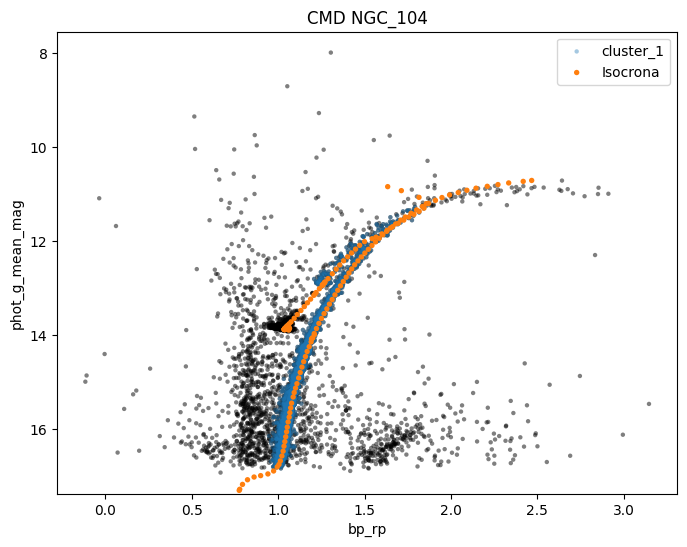

In [58]:
fig, ax = gc_object.plot_cmd(
    clusters=gc_object.clustering_results.main_label, 
    df_isochrone=df_iso, 
    isochrone_distance_module=distance_module,
    isochrone_redding=redding,
    figsize=(8,6)
)
ax.set_ylim(17.3839718, 7.5388882)
ax.set_xlim(-0.2782489265, 3.3085957965)
plt.legend()
plt.savefig("../figures/cmd_47tucanae.png")

## Distribución de masas de 47 Tucanae.

In [42]:
df_gc = gc_object.clustering_results.remove_outliers_gc(random_state=123).copy()

df_gc["pmra_kms"] = df_gc["pmra_kms"] - df_gc["pmra_kms"].mean()
df_gc["pmdec_kms"] = df_gc["pmdec_kms"] - df_gc["pmdec_kms"].mean()
df_gc["radial_velocity"] = df_gc["radial_velocity"] - df_gc["radial_velocity"].mean()

df_gc["v_tan"] = np.sqrt(df_gc.pmra_kms**2 + df_gc.pmdec_kms**2)
df_gc["v_3d"] = np.sqrt(df_gc.v_tan**2 + df_gc.radial_velocity**2)
sigma_v = df_gc["v_3d"].std()
print("Estrellas con velocidad radial: %i" % (~df_gc["radial_velocity"].isna()).sum())
print("Dispersión de velocides calculadas: %f" % sigma_v)

Estrellas con velocidad radial: 581
Dispersión de velocides calculadas: 9.512240


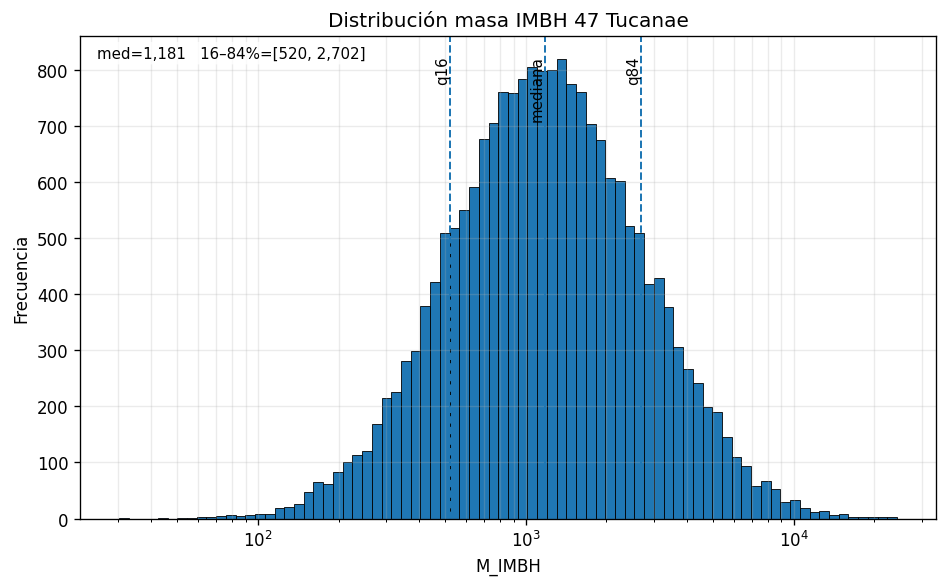

In [59]:
log10_mh, scatter_dex = estimate_log10_mbh_from_sigma(sigma_v)
imbh_sample = sample_mbh(log10_mh, scatter_dex, size=20000, seed=123)
hist_sample(imbh_sample, title="Distribución masa IMBH 47 Tucanae", xlabel="M_IMBH", ylabel="Frecuencia")
plt.savefig("../figures/imbh_distribution_47tucanae.png")

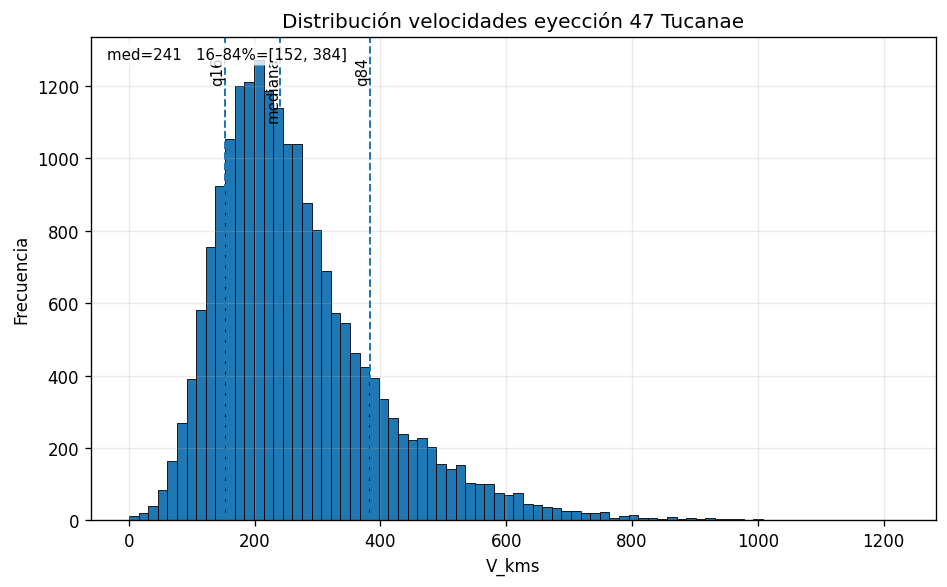

In [60]:
v_ej_sample = v_ejections_sample(
    a_space=(0.05,0.5),
    m_bin_space=(0.6, 1.7),
    sigma_kms=sigma_v,
    sigma_f=0.3,
    size=20000,
    seed=123
)

hist_sample(v_ej_sample, title="Distribución velocidades eyección 47 Tucanae", xlabel="V_kms", ylabel="Frecuencia", logx=False)
plt.savefig("../figures/v_eject_47tucanae.png")

In [68]:
df_highlights_stars=get_hvs_candidates(gc_object, np.quantile(v_ej_sample, 0.84), random_state=123)

df_highlights_stars.shape

(3, 159)

'https://sky.esa.int/esasky/?target=305.88309679902136%20-44.89619341045216&hips=DSS2+color&fov=1.5412867810412323&projection=SIN&cooframe=GALACTIC&sci=false&lang=es'

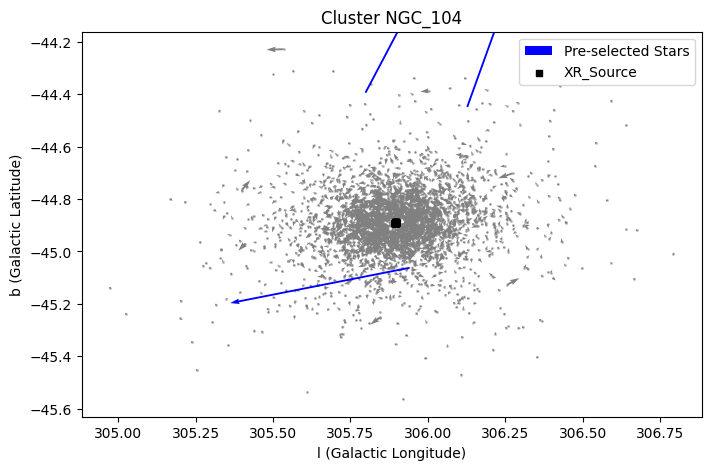

In [69]:
fig, ax = gc_object.plot_cluster(highlight_stars=df_highlights_stars, factor_size=15)
plt.savefig("../figures/cluster_47tucanae.png")
lmin, lmax = ax.get_xlim() 
bmin, bmax = ax.get_ylim() 

l0  = 0.5*(lmin + lmax)
b0  = 0.5*(bmin + bmax)
dl  = (lmax - lmin)
db  = (bmax - bmin)

width_eff  = dl * np.cos(np.deg2rad(abs(b0)))  # grados
height_eff = db                                # grados
fov = max(width_eff, height_eff) * 1.05        # margen 5%

URL = f"https://sky.esa.int/esasky/?target={l0}%20{b0}&hips=DSS2+color&fov={fov}&projection=SIN&cooframe=GALACTIC&sci=false&lang=es"
URL

/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/src/venv/lib/python3.11/site-packages/astropy/visualization/lupton_rgb.py:305: RuntimeWarning: invalid value encountered in divide
  fInorm = np.where(Int <= 0, 0, np.true_divide(fI, Int))


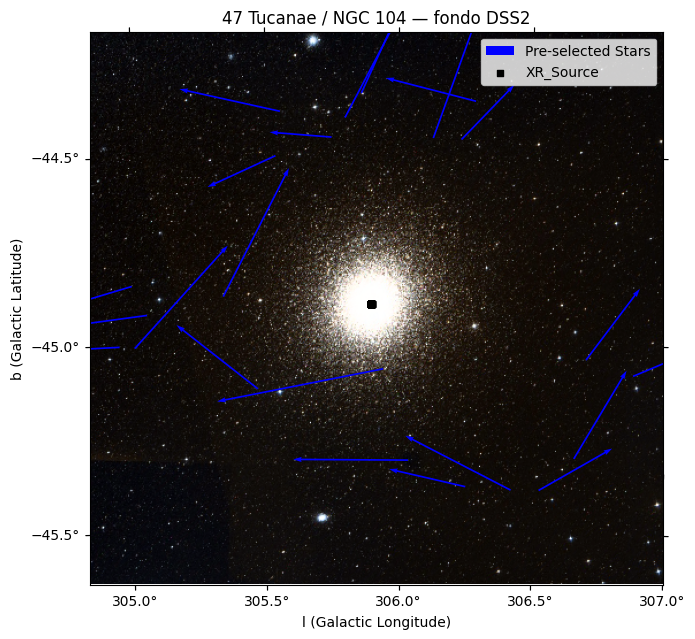

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb


# se ha extraido de https://aladin.cds.unistra.fr/AladinLite/
file = "/home/santhiperbolico/Descargas/cutout-CDS_P_DSS2_color (4).fits"

# 1) Abrir el HDU que tiene datos 2D/3D (a veces es [1] y no [0])
hdul = fits.open(file)
# Busca el primer HDU con datos de al menos 2D
hdu = next(h for h in hdul if hasattr(h, "data") and isinstance(h.data, np.ndarray) and h.data.ndim >= 2)

# 2) WCS celestial (solo los ejes del cielo)
wcs_full = WCS(hdu.header)
wcs = wcs_full.celestial  # <-- esto evita el error de "más de 2 dimensiones"

# 3) Imagen 2D a partir del cubo:
data = hdu.data
r_ch, g_ch, b_ch = data[0], data[1], data[2]

def clip01(img, p_lo=1, p_hi=99.5):
    vmin, vmax = np.nanpercentile(img, [p_lo, p_hi])
    img = np.clip((img - vmin) / (vmax - vmin + 1e-12), 0, 1)
    return img

r = clip01(r_ch, 1, 99.9)
g = clip01(g_ch, 1, 99.9)
b = clip01(b_ch, 1, 99.9)

# --- composición RGB con asinh (Lupton) ---
# Q y stretch controlan el contraste global (ajústalos si quieres)
rgb = make_lupton_rgb(r, g, b, Q=1, stretch=0.8)

fig = plt.figure(figsize=(12,9))
ax = plt.subplot(projection=wcs)
ax.imshow(rgb, origin="lower")

ax.coords[0].set_format_unit(u.deg, decimal=True)
ax.coords[1].set_format_unit(u.deg, decimal=True)
ax.invert_xaxis()

df_gc = gc_object.df_stars
df_source_x = gc_object.xrsource.data
df_source_x = df_source_x[df_source_x.main_id == gc_object.name]
factor_size = 15
hvs_kms = 200


tr = ax.get_transform('galactic')
lon = ax.coords[0];
lat = ax.coords[1]
lon.set_format_unit(u.deg, decimal=True)
lat.set_format_unit(u.deg, decimal=True)
lon.set_axislabel("l (Galactic Longitude)")
lat.set_axislabel("b (Galactic Latitude)")


mean_pm_l = df_gc["pm_l"].mean()
mean_pm_b = df_gc["pm_b"].mean()

mean_pm_ra_kms = df_gc["pmra_kms"].mean()
mean_pm_dec_kms = df_gc["pmdec_kms"].mean()

ax.quiver(
    df_highlights_stars.l* u.deg,
    df_highlights_stars.b* u.deg,
    (df_highlights_stars.pm_l - mean_pm_l) / factor_size,
    (df_highlights_stars.pm_b - mean_pm_b) / factor_size,
    color="blue",
    scale=5,
    width=0.003,
    label="Pre-selected Stars",
    transform=tr,
)

ax.scatter(
    df_source_x.lii.values* u.deg,
    df_source_x.bii.values* u.deg,
    marker="s",
    s=20,
    color="k",
    label="XR_Source",
    transform=tr,
)

# --- 2) Esquinas del rectángulo en (l,b) -> ICRS (RA/Dec) ---
corners_gal = SkyCoord(
    l=[lmin, lmax, lmin, lmax]*u.deg,
    b=[bmin, bmax, bmax, bmin]*u.deg,
    frame="galactic"
)
corners_icrs = corners_gal.icrs

# --- 3) RA/Dec -> píxeles con el WCS 2D que usaste en projection=wcs ---
# (suponiendo que 'wcs' es el WCS celestial del FITS: wcs = WCS(hdu.header).celestial)
xp, yp = wcs.world_to_pixel(corners_icrs)

# --- 4) Fijar límites en píxeles (zoom) ---
ax.set_xlim(np.max(xp), np.min(xp))
ax.set_ylim(np.min(yp), np.max(yp))

ax.set_title("47 Tucanae / NGC 104 — fondo DSS2")
ax.legend(loc="upper right", frameon=True)
plt.tight_layout()
plt.show()
fig.savefig("../figures/cluster_onsky_47tucanae.png")